In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [2]:
df = pd.read_pickle('combined_df.pkl')

In [3]:
df = df.dropna(subset=['image'])

In [4]:
# Mapping dictionary
engagement_mapping = {
    "not engaged": [
        "isolation", "neglect", "pity", "sentimentality", "loneliness", "gloom", "alienation", "defeat", "anguish", "dejection",
        "hopelessness", "melancholy", "depression", "homesickness", "longing"
    ],
    "engaged-positive": [
        "lust", "desire", "infatuation", "passion", "attraction", "liking",
        "excitement", "hope", "optimism", "eagerness", "zeal", "arousal", "joy", "zest",
        "cheerfulness", "happiness", "elation", "rapture", "enjoyment", "gladness",
        "bliss", "gaiety", "jubilation", "delight", "euphoria", "jolliness", "joviality",
        "glee", "ecstasy", "caring", "love", "tenderness", "affection", "adoration",
        "fondness", "compassion", "sympathy", "pleasure", "pride", "satisfaction",
        "contentment", "relief", "triumph", "enthusiasm", "amusement", "surprise",
        "astonishment", "amazement", "shock", "thrill", "exhilaration", "enthrallment"
    ],
    "engaged-negative": [
        "irritation", "wrath", "annoyance", "rage", "aggravation", "anger", "resentment",
        "grumpiness", "frustration", "fury", "hostility", "exasperation", "outrage",
        "grouchiness", "spite", "unhappiness", "disappointment", "insult",
        "rejection", "agitation", "bitterness", "hate",
        "disgust", "dislike", "contempt", "scorn", "displeasure", "envy", "loathing",
        "jealousy", "revulsion", "nervousness", "alarm", "fear", "fright", "horror",
        "terror", "dread", "hysteria", "dismay", "apprehension", "worry", "panic",
        "tenseness", "uneasiness", "anxiety", "suffering", "hurt", "agony",
        "insecurity", "distress", "torment", "sadness", "grief", "glumness", "sorrow", "despair", "misery", "woe", "regret", "guilt", "shame", "embarrassment", "mortification",
        "remorse", "humiliation"
    ]
}

# Step 1: Flatten the mapping
flat_mapping = {}
for engagement_type, labels in engagement_mapping.items():
    for label in labels:
        flat_mapping[label] = engagement_type

# Step 2: Apply mapping to your DataFrame
df['engagement_type'] = df['label'].map(flat_mapping)

# Step 3: Optional - check distribution
print(df['engagement_type'].value_counts())




engagement_type
engaged-negative    13160
engaged-positive    12874
not engaged          3652
Name: count, dtype: int64


In [5]:
# Step 1: Define the target sample size
min_class_size = df['engagement_type'].value_counts().min()

# Step 2: Sample each class down to the minimum size
df_balanced = (
    df.groupby('engagement_type', group_keys=False)
      .apply(lambda x: x.sample(n=min_class_size, random_state=42))
      .reset_index(drop=True)
)

# Step 3: Check the balance
print(df_balanced['engagement_type'].value_counts())

engagement_type
engaged-negative    3652
engaged-positive    3652
not engaged         3652
Name: count, dtype: int64


C:\Users\alina\AppData\Local\Temp\ipykernel_13940\3667488993.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_class_size, random_state=42))


In [7]:
# Encode labels
le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['engagement_type'])

In [8]:
# Split
train_df, val_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

In [9]:
class EngagementDataset(Dataset):
    def __init__(self, dataframe):
        self.images = dataframe['image'].tolist()
        self.labels = dataframe['label'].tolist()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [10]:
batch_size = 32

train_dataset = EngagementDataset(train_df)
val_dataset = EngagementDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [12]:
num_classes = len(le.classes_)

model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

C:\Users\alina\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\alina\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\alina/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:26<00:00, 9.17MB/s]


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
num_epochs = 10

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # -------- VALIDATION --------
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), torch.tensor(labels).to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total

    # -------- LOG RESULTS --------
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")


C:\Users\alina\AppData\Local\Temp\ipykernel_13940\3431682102.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)
C:\Users\alina\AppData\Local\Temp\ipykernel_13940\3431682102.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = images.to(device), torch.tensor(labels).to(device)


Epoch 1/10 | Train Loss: 0.9983 | Val Accuracy: 54.52%
Epoch 2/10 | Train Loss: 0.8693 | Val Accuracy: 54.43%
Epoch 3/10 | Train Loss: 0.7733 | Val Accuracy: 57.57%
Epoch 4/10 | Train Loss: 0.6618 | Val Accuracy: 58.67%
Epoch 5/10 | Train Loss: 0.5314 | Val Accuracy: 57.66%
Epoch 6/10 | Train Loss: 0.4209 | Val Accuracy: 58.12%
Epoch 7/10 | Train Loss: 0.3234 | Val Accuracy: 58.21%
Epoch 8/10 | Train Loss: 0.2446 | Val Accuracy: 56.57%
Epoch 9/10 | Train Loss: 0.2001 | Val Accuracy: 57.03%
Epoch 10/10 | Train Loss: 0.1886 | Val Accuracy: 58.44%


In [17]:
num_epochs = 20

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # -------- VALIDATION --------
    model.eval()
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    # -------- LOG RESULTS --------
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch 1/20 | Train Loss: 0.1634 | Train Acc: 93.82% | Val Acc: 58.03%
Epoch 2/20 | Train Loss: 0.1314 | Train Acc: 95.22% | Val Acc: 58.99%
Epoch 3/20 | Train Loss: 0.1205 | Train Acc: 95.56% | Val Acc: 58.44%
Epoch 4/20 | Train Loss: 0.1230 | Train Acc: 95.12% | Val Acc: 58.49%
Epoch 5/20 | Train Loss: 0.1054 | Train Acc: 95.46% | Val Acc: 58.53%
Epoch 6/20 | Train Loss: 0.1010 | Train Acc: 95.64% | Val Acc: 58.35%
Epoch 7/20 | Train Loss: 0.1255 | Train Acc: 94.84% | Val Acc: 57.85%
Epoch 8/20 | Train Loss: 0.1004 | Train Acc: 95.58% | Val Acc: 57.16%
Epoch 9/20 | Train Loss: 0.0917 | Train Acc: 95.65% | Val Acc: 58.35%
Epoch 10/20 | Train Loss: 0.0843 | Train Acc: 96.18% | Val Acc: 57.66%
Epoch 11/20 | Train Loss: 0.0978 | Train Acc: 95.87% | Val Acc: 58.30%
Epoch 12/20 | Train Loss: 0.0949 | Train Acc: 96.09% | Val Acc: 57.39%
Epoch 13/20 | Train Loss: 0.0811 | Train Acc: 96.36% | Val Acc: 57.89%
Epoch 14/20 | Train Loss: 0.0772 | Train Acc: 96.42% | Val Acc: 58.44%
Epoch 15/20 | T

In [44]:
torch.save(model, "alexnet_full_model.pth")

### Changing the learning rate from 1e-4 to 1e-5

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [22]:
num_epochs = 20

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # -------- VALIDATION --------
    model.eval()
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    # -------- LOG RESULTS --------
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch 1/20 | Train Loss: 0.0420 | Train Acc: 97.54% | Val Acc: 57.66%
Epoch 2/20 | Train Loss: 0.0411 | Train Acc: 97.50% | Val Acc: 57.53%
Epoch 3/20 | Train Loss: 0.0383 | Train Acc: 97.70% | Val Acc: 58.35%
Epoch 4/20 | Train Loss: 0.0380 | Train Acc: 97.74% | Val Acc: 57.94%
Epoch 5/20 | Train Loss: 0.0356 | Train Acc: 97.73% | Val Acc: 58.76%
Epoch 6/20 | Train Loss: 0.0364 | Train Acc: 97.83% | Val Acc: 57.98%
Epoch 7/20 | Train Loss: 0.0358 | Train Acc: 97.91% | Val Acc: 58.35%
Epoch 8/20 | Train Loss: 0.0355 | Train Acc: 97.88% | Val Acc: 58.90%
Epoch 9/20 | Train Loss: 0.0352 | Train Acc: 97.85% | Val Acc: 58.76%
Epoch 10/20 | Train Loss: 0.0365 | Train Acc: 97.97% | Val Acc: 58.76%
Epoch 11/20 | Train Loss: 0.0346 | Train Acc: 97.90% | Val Acc: 58.49%
Epoch 12/20 | Train Loss: 0.0345 | Train Acc: 97.77% | Val Acc: 58.53%
Epoch 13/20 | Train Loss: 0.0333 | Train Acc: 98.00% | Val Acc: 59.03%
Epoch 14/20 | Train Loss: 0.0340 | Train Acc: 97.81% | Val Acc: 58.62%
Epoch 15/20 | T

### Applying higher droput 

AlexNet has default 50% dropout. I will increase it to 60%
Different from difault: 
- learnign rate le-5 (from previous code)
- dropout 0.6

In [25]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.6),                      # ← increased dropout
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.6),                      # ← increased dropout
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, num_classes)
)

In [26]:
model = model.to(device)

In [30]:
num_epochs = 30

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # -------- VALIDATION --------
    model.eval()
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val

    # -------- LOG RESULTS --------
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch 1/30 | Train Loss: 0.9155 | Train Acc: 55.20% | Val Acc: 57.39%
Epoch 2/30 | Train Loss: 0.9122 | Train Acc: 55.66% | Val Acc: 57.21%
Epoch 3/30 | Train Loss: 0.9071 | Train Acc: 56.06% | Val Acc: 57.34%
Epoch 4/30 | Train Loss: 0.8996 | Train Acc: 56.18% | Val Acc: 57.98%
Epoch 5/30 | Train Loss: 0.8965 | Train Acc: 56.36% | Val Acc: 57.94%
Epoch 6/30 | Train Loss: 0.8961 | Train Acc: 56.25% | Val Acc: 57.76%
Epoch 7/30 | Train Loss: 0.8907 | Train Acc: 57.27% | Val Acc: 58.03%
Epoch 8/30 | Train Loss: 0.8854 | Train Acc: 57.28% | Val Acc: 58.03%
Epoch 9/30 | Train Loss: 0.8827 | Train Acc: 57.82% | Val Acc: 57.71%
Epoch 10/30 | Train Loss: 0.8791 | Train Acc: 57.62% | Val Acc: 57.21%
Epoch 11/30 | Train Loss: 0.8759 | Train Acc: 57.83% | Val Acc: 58.12%
Epoch 12/30 | Train Loss: 0.8692 | Train Acc: 58.18% | Val Acc: 58.26%
Epoch 13/30 | Train Loss: 0.8684 | Train Acc: 58.98% | Val Acc: 58.21%
Epoch 14/30 | Train Loss: 0.8668 | Train Acc: 58.75% | Val Acc: 58.03%
Epoch 15/30 | T

### Changing the script a bit to also show Validation, but also to only keep model which shows best results

In [63]:



import copy

num_epochs = 30
best_val_accuracy = 0.0
best_model_state = None

for epoch in range(num_epochs):
    # -------- TRAINING --------
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # -------- VALIDATION --------
    model.eval()
    running_val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # -------- SAVE BEST MODEL --------
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = copy.deepcopy(model.state_dict())  # Save model weights
        print(f"✅ New best model found at epoch {epoch+1} with Val Acc: {val_accuracy:.2f}%")

    # -------- LOG RESULTS --------
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

# -------- LOAD BEST MODEL AFTER TRAINING --------
model.load_state_dict(best_model_state)
print(f"🏁 Best validation accuracy was: {best_val_accuracy:.2f}%")


✅ New best model found at epoch 1 with Val Acc: 60.72%
Epoch 1/30 | Train Loss: 0.5615 | Train Acc: 76.32% | Val Loss: 0.9411 | Val Acc: 60.72%
Epoch 2/30 | Train Loss: 0.5580 | Train Acc: 75.58% | Val Loss: 0.9224 | Val Acc: 60.40%
Epoch 3/30 | Train Loss: 0.5485 | Train Acc: 77.08% | Val Loss: 0.9251 | Val Acc: 59.85%
Epoch 4/30 | Train Loss: 0.5486 | Train Acc: 76.72% | Val Loss: 0.9366 | Val Acc: 60.04%
Epoch 5/30 | Train Loss: 0.5474 | Train Acc: 77.26% | Val Loss: 0.9406 | Val Acc: 59.90%
Epoch 6/30 | Train Loss: 0.5457 | Train Acc: 77.35% | Val Loss: 0.9168 | Val Acc: 59.85%
Epoch 7/30 | Train Loss: 0.5478 | Train Acc: 76.59% | Val Loss: 0.9445 | Val Acc: 59.90%
Epoch 8/30 | Train Loss: 0.5358 | Train Acc: 77.65% | Val Loss: 0.9363 | Val Acc: 59.99%
Epoch 9/30 | Train Loss: 0.5301 | Train Acc: 77.48% | Val Loss: 0.9673 | Val Acc: 59.90%
Epoch 10/30 | Train Loss: 0.5414 | Train Acc: 77.24% | Val Loss: 0.9170 | Val Acc: 60.17%
Epoch 11/30 | Train Loss: 0.5380 | Train Acc: 77.19% |

### Visualizing the results to identify where the model is struggling

<Figure size 800x600 with 0 Axes>

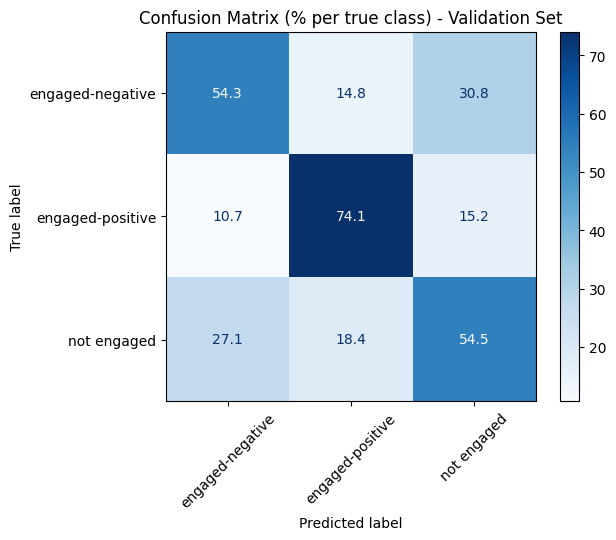

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# Put model in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize by row (i.e., by the number of samples in each true class)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
cm_percent = np.round(cm_percent, 1)  # Round for cleaner display

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=le.classes_)

# Plot it
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, values_format=".1f")  # Show percentages with one decimal
plt.title("Confusion Matrix (% per true class) - Validation Set")
plt.show()


we see that the model does well identifying engaged-positive (correctly identifying 74,1% of cases, but stragles to identify not engaged and engaged-negative cases. 
I will try to see what are the labels with which it strugled a lot. It might be that there was a semantic mistake: emotions from different classes might be close to each other semanticaly and have almost similar face expresion. 

In [67]:
import hashlib

def hash_image(image_array):
    return hashlib.md5(image_array.tobytes()).hexdigest()


In [68]:
# Work on a copy to keep df_balanced safe
df_balanced_copy = df_balanced.copy()
df_balanced_copy['image_hash'] = df_balanced_copy['image'].apply(lambda x: hash_image(x.numpy()))

result_df = result_df.copy()
result_df['image_hash'] = result_df['image'].apply(lambda x: hash_image(x.numpy()))


In [69]:
merged_df = result_df.merge(df_balanced_copy, on='image_hash', how='left', suffixes=('', '_original'))

In [70]:
merged_df.columns

Index(['image', 'engagement_type', 'predicted engagement type', 'image_np',
       'image_hash', 'name', 'description', 'label', 'base_name',
       'emotion_category', 'image_original', 'engagement_type_original',
       'image_id'],
      dtype='object')

In [72]:
merged_df[['engagement_type', 'predicted engagement type', 'label', 'base_name']].head()

engagement_type predicted engagement type  label  \
0  engaged-negative          engaged-positive      0   
1  engaged-negative               not engaged      0   
2  engaged-negative          engaged-positive      0   
3  engaged-negative          engaged-positive      0   
4  engaged-negative          engaged-positive      1   

                                     base_name  
0                     alamy_dislike_look_13_93  
1             bigstockphoto_sorrow_look_150_66  
2                  alamy_disgust_emotion_14_93  
3          bigstockphoto_hate_portrait_1200_69  
4  bigstockphoto_tenderness_expression_1350_10

In [ ]:
merged_df

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping inpu

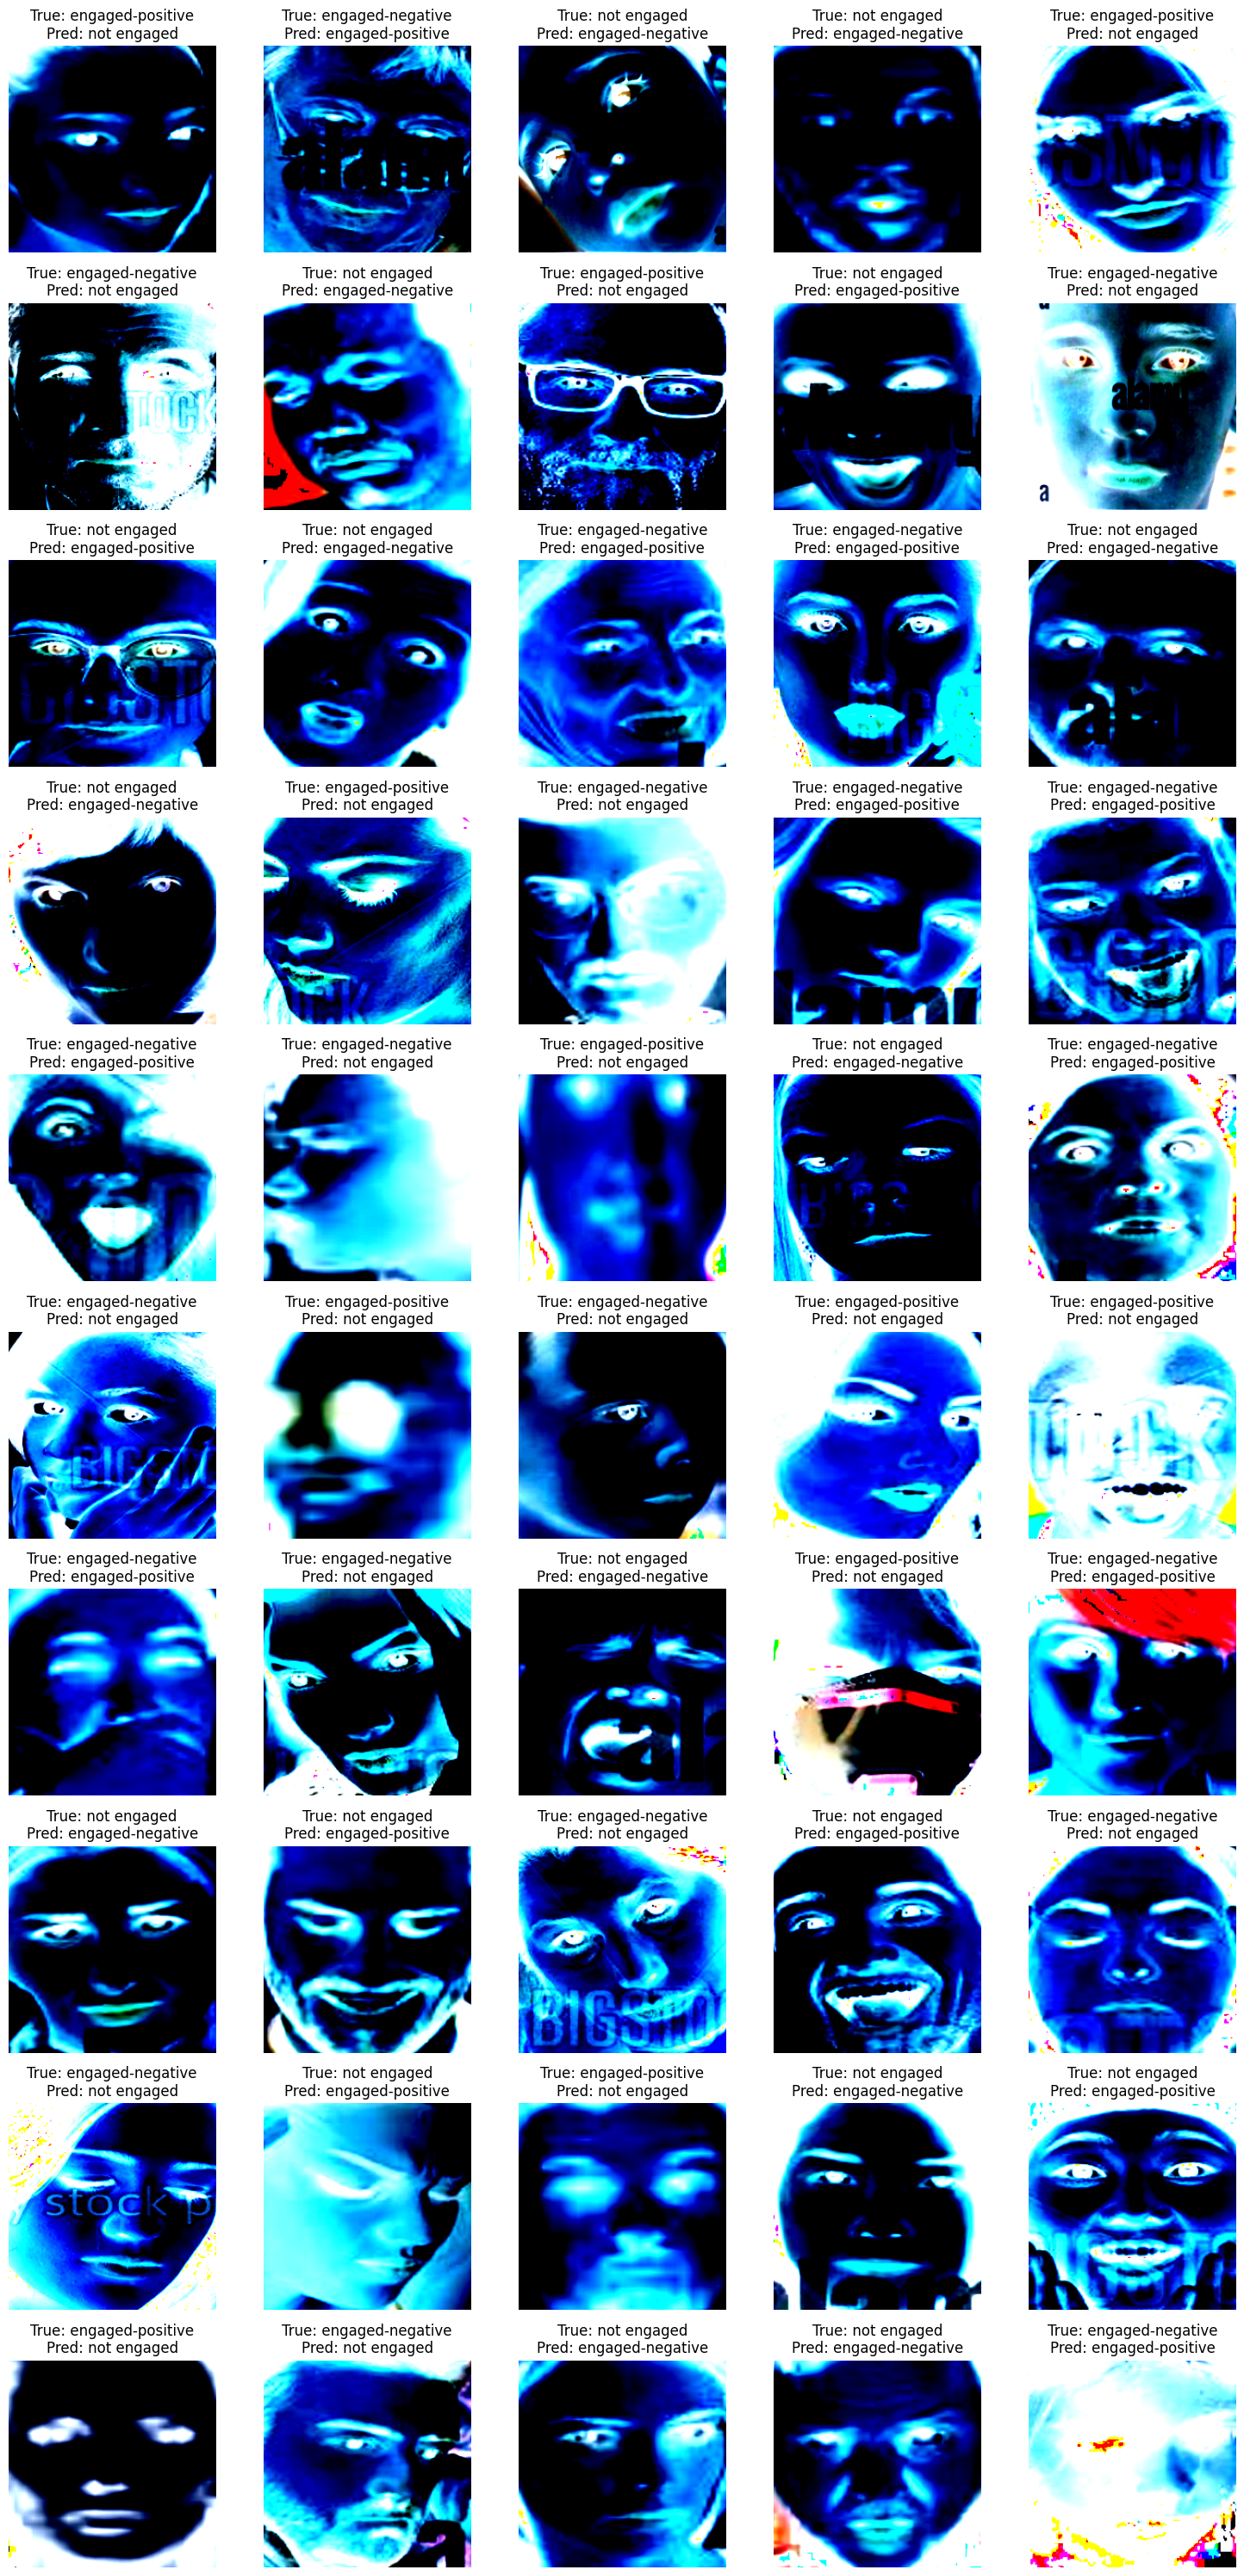

In [33]:
import matplotlib.pyplot as plt
import torch

model.eval()

misclassified = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Find indices where prediction != label
        mismatches = (predicted != labels).nonzero(as_tuple=True)[0]

        for idx in mismatches:
            misclassified.append((
                images[idx].cpu(),  # image tensor
                labels[idx].item(),  # true label index
                predicted[idx].item()  # predicted label index
            ))

        if len(misclassified) >= 50:
            break

# Plot the first 50 misclassified examples
num_to_show = min(50, len(misclassified))
cols = 5
rows = (num_to_show + cols - 1) // cols
plt.figure(figsize=(15, rows * 3))

for i in range(num_to_show):
    img_tensor, true_idx, pred_idx = misclassified[i]
    img_np = img_tensor.permute(1, 2, 0).numpy()  # convert [C,H,W] → [H,W,C]
    
    # Unnormalize if needed (optional, depending on preprocessing)
    # img_np = img_np * std + mean  # if normalized

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {le.classes_[true_idx]}\nPred: {le.classes_[pred_idx]}")

plt.tight_layout()
plt.show()


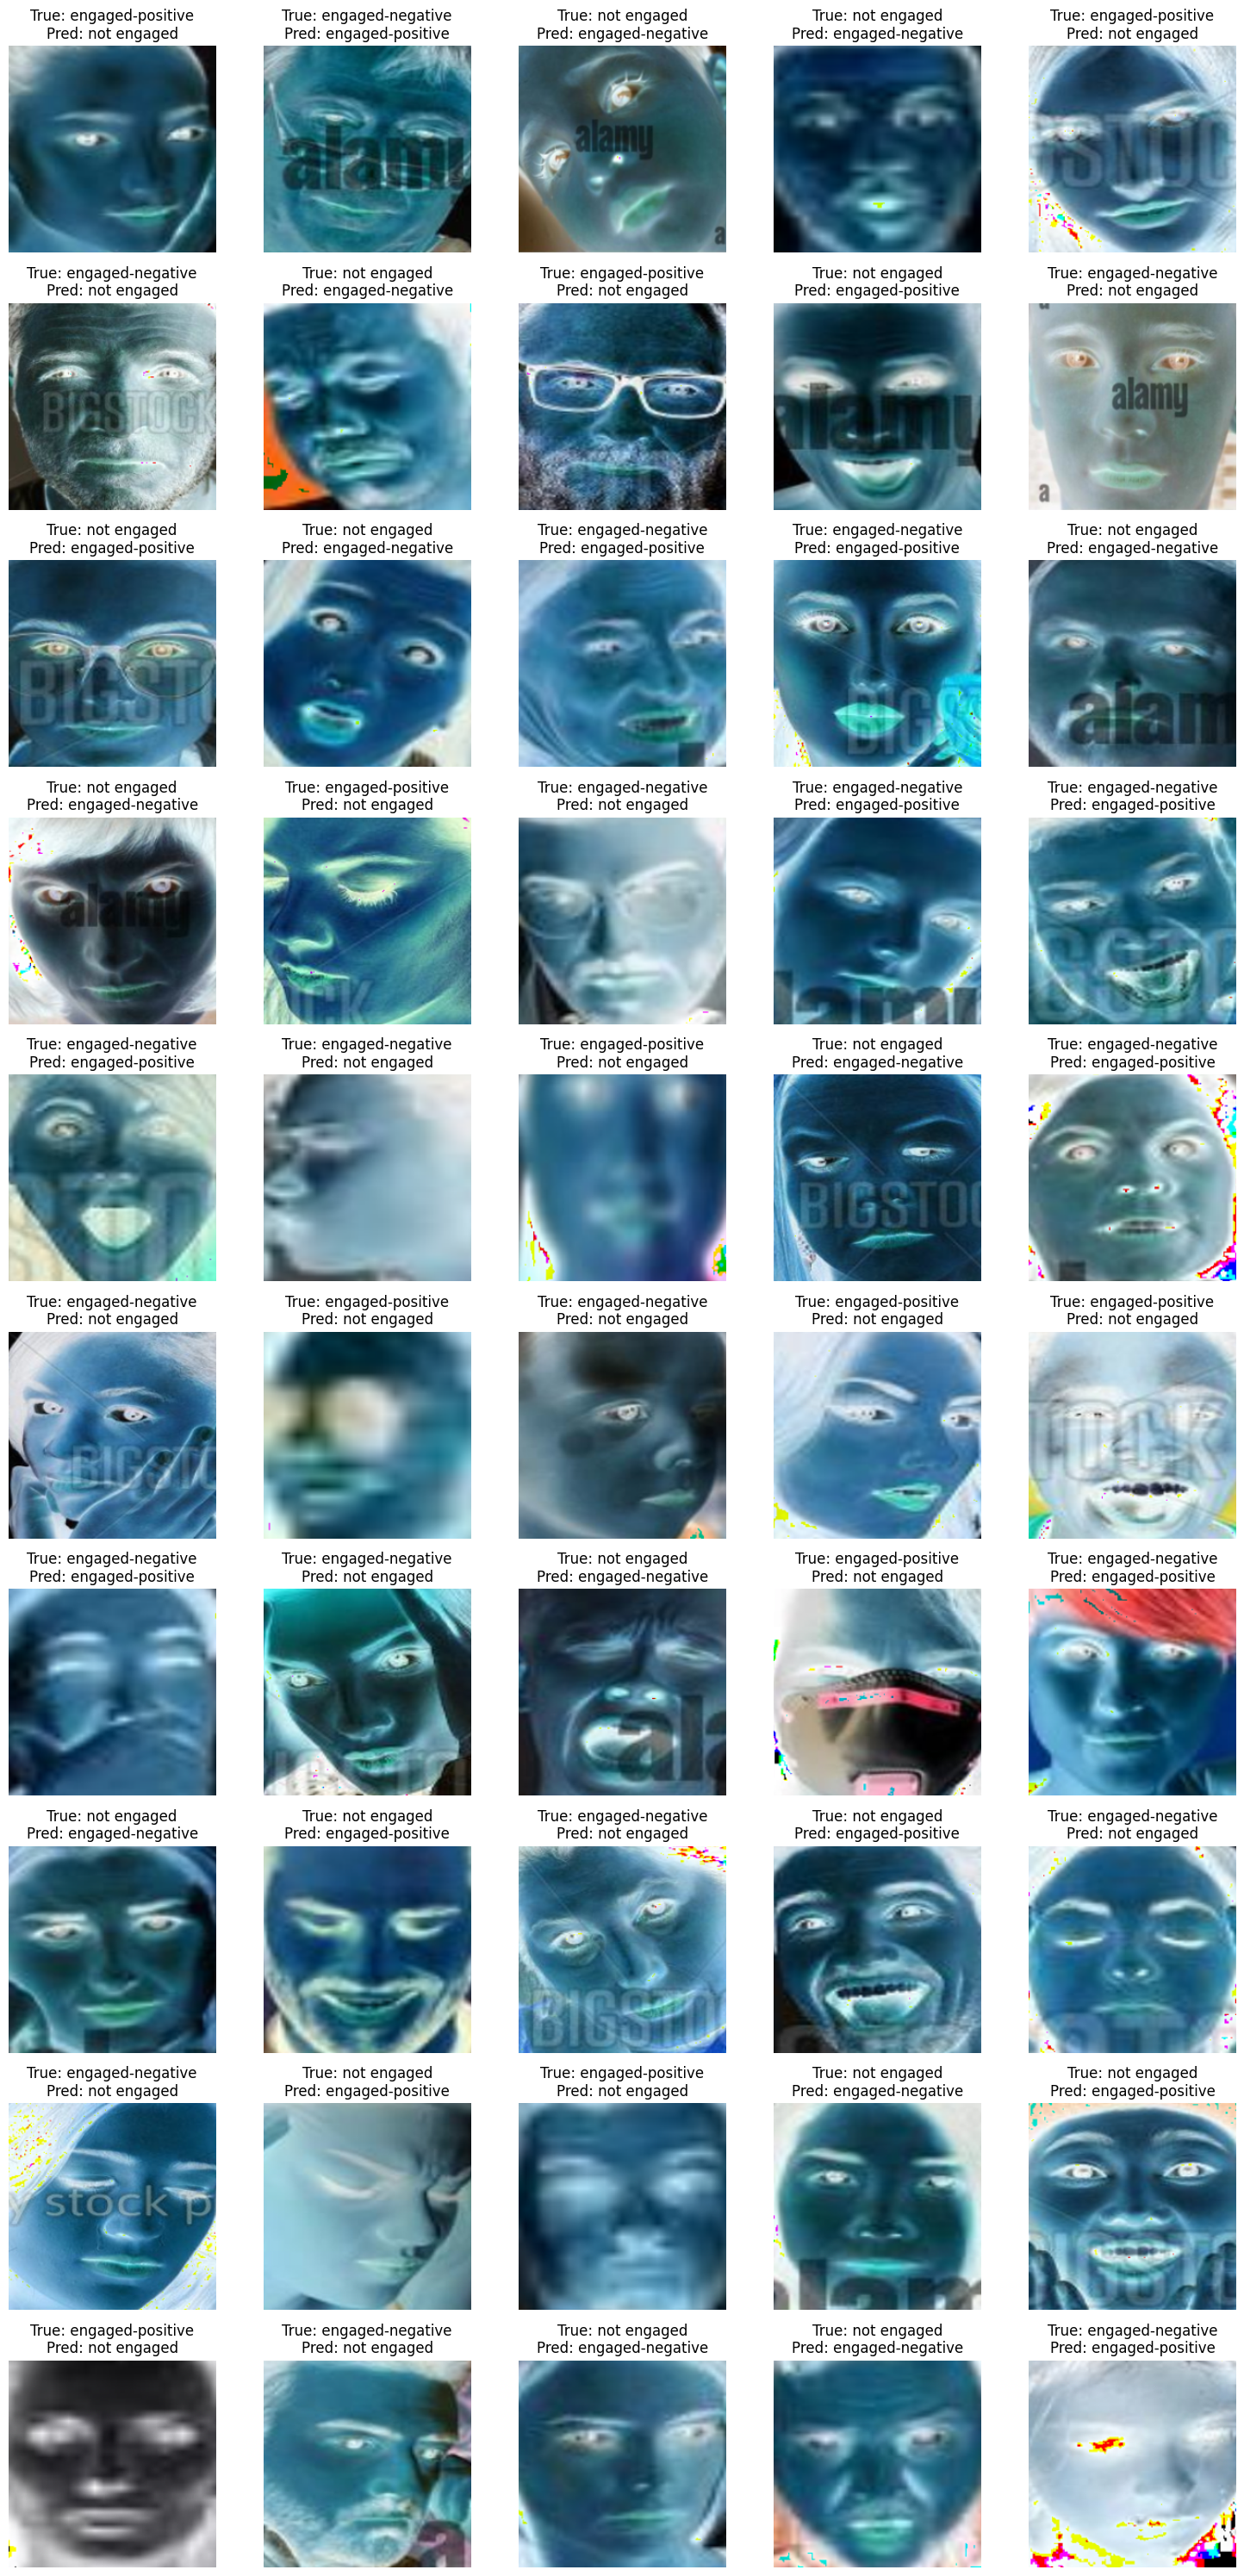

In [35]:
import matplotlib.pyplot as plt
import torch

# Define mean and std as tensors (ImageNet values you used)
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)

# Show the first 50 misclassified images
num_to_show = min(50, len(misclassified))
cols = 5
rows = (num_to_show + cols - 1) // cols
plt.figure(figsize=(15, rows * 3))

for i in range(num_to_show):
    img_tensor, true_idx, pred_idx = misclassified[i]

    # Unnormalize using broadcasting
    img_tensor = img_tensor * std + mean

    # Clamp to [0, 1] and convert to numpy [H, W, C]
    img_np = img_tensor.permute(1, 2, 0).clamp(0, 1).numpy()

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {le.classes_[true_idx]}\nPred: {le.classes_[pred_idx]}")

plt.tight_layout()
plt.show()


In [39]:
df_balanced.columns

Index(['name', 'description', 'label', 'base_name', 'emotion_category',
       'image', 'engagement_type'],
      dtype='object')

In [1]:
print(model)

NameError: name 'model' is not defined